# Preparations

In [4]:
import torch
torch.cuda.is_available()

/home/dima/anaconda3/envs/dla/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [5]:
# %%bash

# #download LjSpeech
# wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2 -o /dev/null
# mkdir data
# tar -xvf LJSpeech-1.1.tar.bz2 >> /dev/null
# mv LJSpeech-1.1 data/LJSpeech-1.1

# gdown https://drive.google.com/u/0/uc?id=1-EdH0t0loc6vPiuVtXdhsDtzygWNSNZx
# mv train.txt data/

# #download Waveglow
# gdown https://drive.google.com/u/0/uc?id=1WsibBTsuRg_SF2Z6L6NFRTT-NjEy1oTx
# mkdir -p waveglow/pretrained_model/
# mv waveglow_256channels_ljs_v2.pt waveglow/pretrained_model/waveglow_256channels.pt

# gdown https://drive.google.com/u/0/uc?id=1cJKJTmYd905a-9GFoo5gKjzhKjUVj83j
# tar -xvf mel.tar.gz
# echo $(ls mels | wc -l)

# #download alignments
# wget https://github.com/xcmyz/FastSpeech/raw/master/alignments.zip
# unzip alignments.zip >> /dev/null

# # we will use waveglow code, data and audio preprocessing from this repo
# git clone https://github.com/xcmyz/FastSpeech.git
# mv FastSpeech/text .
# mv FastSpeech/audio .
# mv FastSpeech/waveglow/* waveglow/
# mv FastSpeech/utils.py .
# mv FastSpeech/glow.py .

In [2]:
!head -n 5 data/train.txt

Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
in being comparatively modern.
For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process
produced the block books, which were the immediate predecessors of the true printed book,
the invention of movable metal letters in the middle of the fifteenth century may justly be considered as the invention of the art of printing.


In [3]:
import numpy as np

In [4]:
np.load('./alignments/0.npy')

array([ 1,  4,  7,  4,  6, 18,  4,  9, 18,  4,  7,  3,  0,  3,  0,  7,  0,
       16,  3,  4,  8,  0, 14, 12,  7,  2,  5,  0,  5,  6,  0,  4,  0,  6,
        0,  8,  4,  2,  0,  7,  9,  0, 10,  0,  8,  0,  6,  3,  0,  7,  4,
        8,  7,  3,  3,  2,  0,  7,  6,  5, 12,  9, 14,  4,  0,  6, 23, 16,
        2, 10,  3,  3,  4, 12, 11, 12,  2,  2,  4,  5,  0,  8, 15,  9,  3,
        0,  7,  7,  0,  8, 10,  5,  0,  6,  2,  5,  7,  9,  9,  5,  6,  0,
        4,  0,  7,  0,  8,  8,  6,  6,  0,  2,  2,  4,  0,  6,  8, 16,  6,
        6,  7,  0, 10,  8,  5,  3,  4,  6,  8,  2,  3,  7,  4,  6,  9,  6,
        0,  0,  0,  7,  0,  8,  7,  8,  3,  6,  9,  5,  5,  7, 19],
      dtype=int32)

In [5]:
!head -n 1 data/train.txt | wc -m

152


In [19]:
# !pip install -r requirements.txt

# Imports

In [6]:
import pathlib
import random
import itertools
from tqdm import tqdm_notebook

from IPython import display
from dataclasses import dataclass

import torch
import torch.nn.functional as F
from torch import distributions
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchaudio
from torchaudio.transforms import MelSpectrogram
import math
import time
import os
import librosa
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from dataclasses import dataclass
from collections import OrderedDict

import seaborn as sns 
sns.set()

import sys
sys.path.append('.')

# Configs

In [7]:
@dataclass
class MelSpectrogramConfig:
    num_mels = 80

@dataclass
class FastSpeechConfig:
    vocab_size = 300
    max_seq_len = 3000

    encoder_dim = 256
    encoder_n_layer = 4
    encoder_head = 2
    encoder_conv1d_filter_size = 1024

    decoder_dim = 256
    decoder_n_layer = 4
    decoder_head = 2
    decoder_conv1d_filter_size = 1024

    fft_conv1d_kernel = (9, 1)
    fft_conv1d_padding = (4, 0)

    duration_predictor_filter_size = 256
    duration_predictor_kernel_size = 3
    dropout = 0.1
    
    PAD = 0
    UNK = 1
    BOS = 2
    EOS = 3

    PAD_WORD = '<blank>'
    UNK_WORD = '<unk>'
    BOS_WORD = '<s>'
    EOS_WORD = '</s>'


@dataclass
class TrainConfig:
    checkpoint_path = "./model_new"
    logger_path = "./logger"
    mel_ground_truth = "./mels"
    alignment_path = "./alignments"
    data_path = './data/train.txt'
    
    wandb_project = 'fastspeech_example'
    
    text_cleaners = ['english_cleaners']

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = 'cuda:0'

    batch_size = 16
    epochs = 2000
    n_warm_up_step = 4000

    learning_rate = 1e-3
    weight_decay = 1e-6
    grad_clip_thresh = 1.0
    decay_step = [500000, 1000000, 2000000]

    save_step = 3000
    log_step = 5
    clear_Time = 20

    batch_expand_size = 32
    

mel_config = MelSpectrogramConfig()
model_config = FastSpeechConfig()
train_config = TrainConfig()

In [8]:
!

In [9]:
from text import text_to_sequence


def pad_1D(inputs, PAD=0):

    def pad_data(x, length, PAD):
        x_padded = np.pad(x, (0, length - x.shape[0]),
                          mode='constant',
                          constant_values=PAD)
        return x_padded

    max_len = max((len(x) for x in inputs))
    padded = np.stack([pad_data(x, max_len, PAD) for x in inputs])

    return padded


def pad_1D_tensor(inputs, PAD=0):

    def pad_data(x, length, PAD):
        x_padded = F.pad(x, (0, length - x.shape[0]))
        return x_padded

    max_len = max((len(x) for x in inputs))
    padded = torch.stack([pad_data(x, max_len, PAD) for x in inputs])

    return padded


def pad_2D(inputs, maxlen=None):

    def pad(x, max_len):
        PAD = 0
        if np.shape(x)[0] > max_len:
            raise ValueError("not max_len")

        s = np.shape(x)[1]
        x_padded = np.pad(x, (0, max_len - np.shape(x)[0]),
                          mode='constant',
                          constant_values=PAD)
        return x_padded[:, :s]

    if maxlen:
        output = np.stack([pad(x, maxlen) for x in inputs])
    else:
        max_len = max(np.shape(x)[0] for x in inputs)
        output = np.stack([pad(x, max_len) for x in inputs])

    return output


def pad_2D_tensor(inputs, maxlen=None):

    def pad(x, max_len):
        if x.size(0) > max_len:
            raise ValueError("not max_len")

        s = x.size(1)
        x_padded = F.pad(x, (0, 0, 0, max_len-x.size(0)))
        return x_padded[:, :s]

    if maxlen:
        output = torch.stack([pad(x, maxlen) for x in inputs])
    else:
        max_len = max(x.size(0) for x in inputs)
        output = torch.stack([pad(x, max_len) for x in inputs])

    return output


def process_text(train_text_path):
    with open(train_text_path, "r", encoding="utf-8") as f:
        txt = []
        for line in f.readlines():
            txt.append(line)

        return txt


def get_data_to_buffer(train_config):
    buffer = list()
    text = process_text(train_config.data_path)

    start = time.perf_counter()
    for i in tqdm(range(len(text))):

        mel_gt_name = os.path.join(
            train_config.mel_ground_truth, "ljspeech-mel-%05d.npy" % (i+1))
        mel_gt_target = np.load(mel_gt_name)
        duration = np.load(os.path.join(
            train_config.alignment_path, str(i)+".npy"))
        character = text[i][0:len(text[i])-1]
        character = np.array(
            text_to_sequence(character, train_config.text_cleaners))

        character = torch.from_numpy(character)
        duration = torch.from_numpy(duration)
        mel_gt_target = torch.from_numpy(mel_gt_target)

        buffer.append({"text": character, "duration": duration,
                       "mel_target": mel_gt_target})

    end = time.perf_counter()
    print("cost {:.2f}s to load all data into buffer.".format(end-start))

    return buffer


class BufferDataset(Dataset):
    def __init__(self, buffer):
        self.buffer = buffer
        self.length_dataset = len(self.buffer)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, idx):
        return self.buffer[idx]


def reprocess_tensor(batch, cut_list):
    texts = [batch[ind]["text"] for ind in cut_list]
    mel_targets = [batch[ind]["mel_target"] for ind in cut_list]
    durations = [batch[ind]["duration"] for ind in cut_list]

    length_text = np.array([])
    for text in texts:
        length_text = np.append(length_text, text.size(0))

    src_pos = list()
    max_len = int(max(length_text))
    for length_src_row in length_text:
        src_pos.append(np.pad([i+1 for i in range(int(length_src_row))],
                              (0, max_len-int(length_src_row)), 'constant'))
    src_pos = torch.from_numpy(np.array(src_pos))

    length_mel = np.array(list())
    for mel in mel_targets:
        length_mel = np.append(length_mel, mel.size(0))

    mel_pos = list()
    max_mel_len = int(max(length_mel))
    for length_mel_row in length_mel:
        mel_pos.append(np.pad([i+1 for i in range(int(length_mel_row))],
                              (0, max_mel_len-int(length_mel_row)), 'constant'))
    mel_pos = torch.from_numpy(np.array(mel_pos))

    texts = pad_1D_tensor(texts)
    durations = pad_1D_tensor(durations)
    mel_targets = pad_2D_tensor(mel_targets)

    out = {"text": texts,
           "mel_target": mel_targets,
           "duration": durations,
           "mel_pos": mel_pos,
           "src_pos": src_pos,
           "mel_max_len": max_mel_len}

    return out


def collate_fn_tensor(batch):
    len_arr = np.array([d["text"].size(0) for d in batch])
    index_arr = np.argsort(-len_arr)
    batchsize = len(batch)
    real_batchsize = batchsize // train_config.batch_expand_size

    cut_list = list()
    for i in range(train_config.batch_expand_size):
        cut_list.append(index_arr[i*real_batchsize:(i+1)*real_batchsize])

    output = list()
    for i in range(train_config.batch_expand_size):
        output.append(reprocess_tensor(batch, cut_list[i]))

    return output



/home/dima/DLA/TTS/text/__init__.py:75: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/home/dima/DLA/TTS/text/__init__.py:75: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'


In [10]:
buffer = get_data_to_buffer(train_config)

dataset = BufferDataset(buffer)

training_loader = DataLoader(
    dataset,
    batch_size=train_config.batch_expand_size * train_config.batch_size,
    shuffle=True,
    collate_fn=collate_fn_tensor,
    drop_last=True,
    num_workers=0
)

100%|██████████| 13100/13100 [00:10<00:00, 1294.94it/s]

cost 10.12s to load all data into buffer.


In [11]:
batch = next(iter(training_loader))[0]

In [12]:
batch['text'].shape

torch.Size([16, 173])

# Encoder

## Transformer Block

### Scaled Dot Product Attention

Here we have computer q,k,v matricies and we should calc attention score and calc weighted value vectors

<img src="https://img-blog.csdnimg.cn/20190325121034288.png">

In [13]:
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=2)


    def forward(self, q, k, v, mask=None):
        # q, k, v: [ (batch_size * n_heads) x seq_len x hidden_size ]
        
        attn = torch.einsum('BLD,BlD->BLl', q, k)
        attn /= self.temperature

        if mask is not None:
            attn = torch.masked_fill(attn, mask, -torch.inf)

        # attn: [ (batch_size * n_heads) x seq_len x seq_len ]
        attn = self.dropout(self.softmax(attn))
        output = torch.einsum('BLl,BlD->BLD', attn, v)

        # output: [ (batch_size * n_heads) x seq_len x hidden_size ]
        return output, attn

In [14]:
dot_product_attention = ScaledDotProductAttention(1)

q = torch.randn(4 * 4, 8, 4)
k = torch.randn(4 * 4, 8, 4)
v = torch.randn(4 * 4, 8, 4)

output, attn = dot_product_attention(q, k, v)

Посмотрим на аттэншн мапы

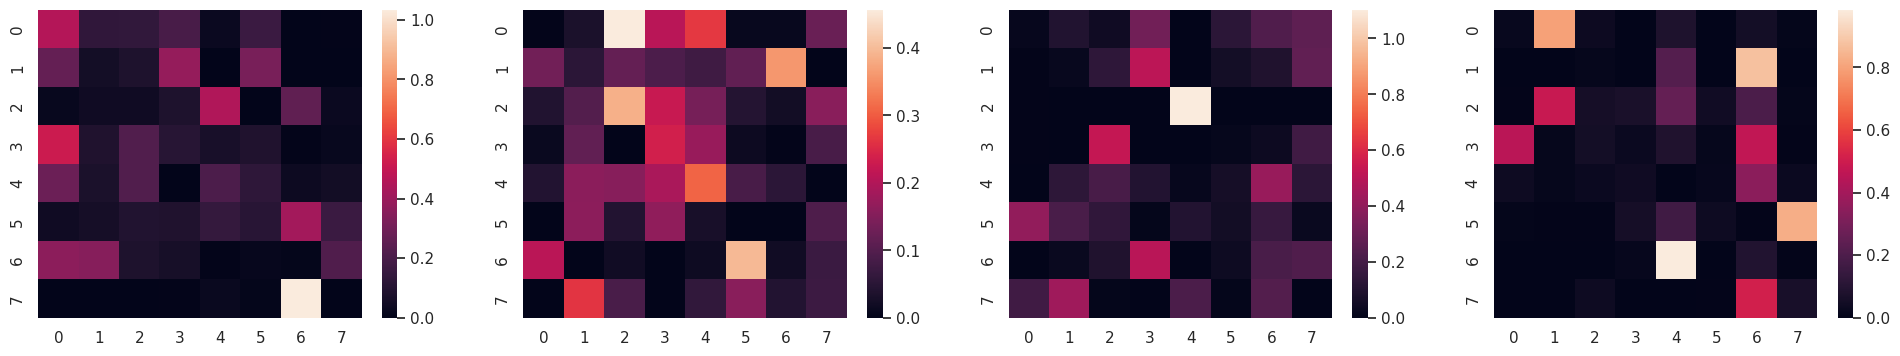

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(24, 4))
for i, at in enumerate(attn[0:4]):
    sns.heatmap(attn[i], ax=ax[i])

### Multi Head Attention

<img src='https://github.com/markovka17/dla/blob/2022/week07/images/attention_picture.png?raw=1'>

Тут инпуты тремя линейными сломи преобразуем для подачи в selt attention

In [16]:
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.d_model = d_model

        self.w_qs = nn.Linear(d_model, n_head * d_k)
        self.w_ks = nn.Linear(d_model, n_head * d_k)
        self.w_vs = nn.Linear(d_model, n_head * d_v)

        self.attention = ScaledDotProductAttention(
            temperature=d_k**0.5) 
        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(n_head * d_v, d_model)
        nn.init.xavier_normal_(self.fc.weight)

        self.dropout = nn.Dropout(dropout)
        
        self.reset_parameters()

    def reset_parameters(self):
         # normal distribution initialization better than kaiming(default in pytorch)
        nn.init.normal_(self.w_qs.weight, mean=0,
                        std=np.sqrt(2.0 / (self.d_model + self.d_k)))
        nn.init.normal_(self.w_ks.weight, mean=0,
                        std=np.sqrt(2.0 / (self.d_model + self.d_k)))
        nn.init.normal_(self.w_vs.weight, mean=0,
                        std=np.sqrt(2.0 / (self.d_model + self.d_v))) 
        
    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head

        sz_b, len_q, _ = q.size()
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()

        residual = q

        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k)  # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k)  # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v)  # (n*b) x lv x dv
        
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)  # (n*b) x .. x ..
        output, attn = self.attention(q, k, v, mask=mask)

        output = output.view(n_head, sz_b, len_q, d_v)
        output = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1)  # b x lq x (n*dv)

        output = self.dropout(self.fc(output))
        output = self.layer_norm(output + residual)

        return output, attn

- Realization from Andrey Karpathy- https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
- Flash Attention - https://arxiv.org/abs/2205.14135

Двухслойная сеть из 1d конволюций с релу в качестве активации. После идет драпаут и layer norm

### Positionwise Feed Forward

In [17]:
class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()

        # Use Conv1D
        # position-wise
        self.w_1 = nn.Conv1d(
            d_in, d_hid, kernel_size=model_config.fft_conv1d_kernel[0], padding=model_config.fft_conv1d_padding[0])
        # position-wise
        self.w_2 = nn.Conv1d(
            d_hid, d_in, kernel_size=model_config.fft_conv1d_kernel[1], padding=model_config.fft_conv1d_padding[1])

        self.layer_norm = nn.LayerNorm(d_in)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        output = x.transpose(1, 2)
        output = self.w_2(F.relu(self.w_1(output)))
        output = output.transpose(1, 2)
        output = self.dropout(output)
        output = self.layer_norm(output + residual)

        return output

### FFTBlock

<img src='https://github.com/markovka17/dla/blob/2022/week07/images/fft.png?raw=1'>

Совмещаем все вместе в один FFT(Feed Forward Transformer) BLock. Теперь можно стакать эти слои

In [18]:
class FFTBlock(torch.nn.Module):
    """FFT Block"""

    def __init__(self,
                 d_model,
                 d_inner,
                 n_head,
                 d_k,
                 d_v,
                 dropout=0.1):
        super(FFTBlock, self).__init__()
        self.slf_attn = MultiHeadAttention(
            n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(
            d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, non_pad_mask=None, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        
        if non_pad_mask is not None:
            enc_output *= non_pad_mask

        enc_output = self.pos_ffn(enc_output)
        
        if non_pad_mask is not None:
            enc_output *= non_pad_mask

        return enc_output, enc_slf_attn

In [19]:
hidden_size = 16
intermediate_size = 64
n_head = 4
batch_size = 4
seq_len = 12

fft_block = FFTBlock(hidden_size, intermediate_size, n_head, hidden_size // n_head, hidden_size // n_head)

inp_tensor = torch.rand(batch_size, seq_len, hidden_size, dtype=torch.float32)

out_tensor = fft_block(inp_tensor)[0]

assert inp_tensor.shape == out_tensor.shape

- Training tips - https://arxiv.org/pdf/1804.00247.pdf
- Transformer without Tears - https://tnq177.github.io/data/transformers_without_tears.pdf

## Length Regulator

### Aligner

In [20]:
def create_alignment(base_mat, duration_predictor_output):
    N, L = duration_predictor_output.shape
    for i in range(N):
        count = 0
        for j in range(L):
            for k in range(duration_predictor_output[i][j]):
                base_mat[i][count+k][j] = 1
            count = count + duration_predictor_output[i][j]
    return base_mat

функция которая делает бинарную матрицу для деблирование каждого мела

In [21]:
create_alignment(
    torch.zeros(1, 6, 3).numpy(),
    torch.LongTensor([[1,2,3]])
)

array([[[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]], dtype=float32)

### Duration Predictor

<img src='https://github.com/markovka17/dla/blob/2022/week07/images/duration_predictor.png?raw=1'>

In [22]:
class Transpose(nn.Module):
    def __init__(self, dim_1, dim_2):
        super().__init__()
        self.dim_1 = dim_1
        self.dim_2 = dim_2

    def forward(self, x):
        return x.transpose(self.dim_1, self.dim_2)


Простая сетка с двумя конволюшналами и Линейным слоем агрегатом. Предсказываем тут длительность каждой фонемы

In [23]:
class DurationPredictor(nn.Module):
    """ Duration Predictor """

    def __init__(self, model_config: FastSpeechConfig):
        super(DurationPredictor, self).__init__()

        self.input_size = model_config.encoder_dim
        self.filter_size = model_config.duration_predictor_filter_size
        self.kernel = model_config.duration_predictor_kernel_size
        self.conv_output_size = model_config.duration_predictor_filter_size
        self.dropout = model_config.dropout

        self.conv_net = nn.Sequential(
            Transpose(-1, -2),
            nn.Conv1d(
                self.input_size, self.filter_size,
                kernel_size=self.kernel, padding=1
            ),
            Transpose(-1, -2),
            nn.LayerNorm(self.filter_size),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            Transpose(-1, -2),
            nn.Conv1d(
                self.filter_size, self.filter_size,
                kernel_size=self.kernel, padding=1
            ),
            Transpose(-1, -2),
            nn.LayerNorm(self.filter_size),
            nn.ReLU(),
            nn.Dropout(self.dropout)
        )

        self.linear_layer = nn.Linear(self.conv_output_size, 1)
        self.relu = nn.ReLU()

    def forward(self, encoder_output):
        encoder_output = self.conv_net(encoder_output)
            
        out = self.linear_layer(encoder_output)
        out = self.relu(out)
        out = out.squeeze()
        if not self.training:
            out = out.unsqueeze(0)
        return out

In [24]:
dur_predictor = DurationPredictor(model_config)

inp_tensor = torch.rand(
    2, # batch_size
    12, #seq_len
    model_config.encoder_dim,
    dtype=torch.float32
)

dur_prediction = dur_predictor(inp_tensor)

In [25]:
dur_prediction

tensor([[0.2786, 0.2115, 0.3364, 0.2446, 0.3571, 0.3957, 0.0000, 0.2793, 0.3473,
         0.0965, 0.0354, 0.1384],
        [0.0000, 0.5672, 0.0000, 0.0000, 0.0239, 0.3439, 0.1991, 0.4109, 0.2195,
         0.4215, 0.1083, 0.2145]], grad_fn=<SqueezeBackward0>)

In [26]:
class LengthRegulator(nn.Module):
    """ Length Regulator """

    def __init__(self, model_config):
        super(LengthRegulator, self).__init__()
        self.duration_predictor = DurationPredictor(model_config)

    def LR(self, x, duration_predictor_output, mel_max_length=None):
        expand_max_len = torch.max(
            torch.sum(duration_predictor_output, -1), -1)[0]
        alignment = torch.zeros(duration_predictor_output.size(0),
                                expand_max_len,
                                duration_predictor_output.size(1)).numpy()
        alignment = create_alignment(alignment,
                                     duration_predictor_output.cpu().numpy())
        alignment = torch.from_numpy(alignment).to(x.device)

        output = alignment @ x
        if mel_max_length:
            output = F.pad(
                output, (0, 0, 0, mel_max_length-output.size(1), 0, 0))
        return output

    def forward(self, x, alpha=1.0, target=None, mel_max_length=None):
        ### Your code here
        duration_predictor_output = self.duration_predictor(x)

        if target is not None:
            output = self.LR(x, target, mel_max_length)
            return output, duration_predictor_output
        else:
            output = self.LR(x, (duration_predictor_output * alpha + 0.5).int(), mel_max_length)
            return output

Класс который все объеденяет

## Final BLock

### Attention masks

In [27]:
def get_non_pad_mask(seq):
    assert seq.dim() == 2
    return seq.ne(model_config.PAD).type(torch.float).unsqueeze(-1)

def get_attn_key_pad_mask(seq_k, seq_q):
    ''' For masking out the padding part of key sequence. '''
    # Expand to fit the shape of key query attention matrix.
    len_q = seq_q.size(1)
    padding_mask = seq_k.eq(model_config.PAD)
    padding_mask = padding_mask.unsqueeze(
        1).expand(-1, len_q, -1)  # b x lq x lk

    return padding_mask

Энкодер и Декодер, берем FFT слои и цикликом по ним проходим. В энкодере эмбединги токенов и позишн эмбединги

### Encoder

In [28]:
class Encoder(nn.Module):
    def __init__(self, model_config):
        super(Encoder, self).__init__()
        
        len_max_seq=model_config.max_seq_len
        n_position = len_max_seq + 1
        n_layers = model_config.encoder_n_layer

        self.src_word_emb = nn.Embedding(
            model_config.vocab_size,
            model_config.encoder_dim,
            padding_idx=model_config.PAD
        )

        self.position_enc = nn.Embedding(
            n_position,
            model_config.encoder_dim,
            padding_idx=model_config.PAD
        )

        self.layer_stack = nn.ModuleList([FFTBlock(
            model_config.encoder_dim,
            model_config.encoder_conv1d_filter_size,
            model_config.encoder_head,
            model_config.encoder_dim // model_config.encoder_head,
            model_config.encoder_dim // model_config.encoder_head,
            dropout=model_config.dropout
        ) for _ in range(n_layers)])

    def forward(self, src_seq, src_pos, return_attns=False):

        enc_slf_attn_list = []

        # -- Prepare masks
        slf_attn_mask = get_attn_key_pad_mask(seq_k=src_seq, seq_q=src_seq)
        non_pad_mask = get_non_pad_mask(src_seq)
        
        # -- Forward
        enc_output = self.src_word_emb(src_seq) + self.position_enc(src_pos)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(
                enc_output,
                non_pad_mask=non_pad_mask,
                slf_attn_mask=slf_attn_mask)
            if return_attns:
                enc_slf_attn_list += [enc_slf_attn]
        

        return enc_output, non_pad_mask

In [29]:
class Decoder(nn.Module):
    """ Decoder """

    def __init__(self, model_config):

        super(Decoder, self).__init__()

        len_max_seq=model_config.max_seq_len
        n_position = len_max_seq + 1
        n_layers = model_config.decoder_n_layer

        self.position_enc = nn.Embedding(
            n_position,
            model_config.encoder_dim,
            padding_idx=model_config.PAD,
        )

        self.layer_stack = nn.ModuleList([FFTBlock(
            model_config.encoder_dim,
            model_config.encoder_conv1d_filter_size,
            model_config.encoder_head,
            model_config.encoder_dim // model_config.encoder_head,
            model_config.encoder_dim // model_config.encoder_head,
            dropout=model_config.dropout
        ) for _ in range(n_layers)])

    def forward(self, enc_seq, enc_pos, return_attns=False):

        dec_slf_attn_list = []

        # -- Prepare masks
        slf_attn_mask = get_attn_key_pad_mask(seq_k=enc_pos, seq_q=enc_pos)
        non_pad_mask = get_non_pad_mask(enc_pos)

        # -- Forward
        dec_output = enc_seq + self.position_enc(enc_pos)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn = dec_layer(
                dec_output,
                non_pad_mask=non_pad_mask,
                slf_attn_mask=slf_attn_mask)
            if return_attns:
                dec_slf_attn_list += [dec_slf_attn]

        return dec_output
    

In [30]:
def get_mask_from_lengths(lengths, max_len=None):
    if max_len == None:
        max_len = torch.max(lengths).item()

    ids = torch.arange(0, max_len, 1, device=lengths.device)
    mask = (ids < lengths.unsqueeze(1)).bool()

    return mask

In [31]:
class FastSpeech(nn.Module):
    """ FastSpeech """

    def __init__(self, model_config):
        super(FastSpeech, self).__init__()

        self.encoder = Encoder(model_config)
        self.length_regulator = LengthRegulator(model_config)
        self.decoder = Decoder(model_config)

        self.mel_linear = nn.Linear(model_config.decoder_dim, mel_config.num_mels)

    def mask_tensor(self, mel_output, position, mel_max_length):
        lengths = torch.max(position, -1)[0]
        mask = ~get_mask_from_lengths(lengths, max_len=mel_max_length)
        mask = mask.unsqueeze(-1).expand(-1, -1, mel_output.size(-1))
        return mel_output.masked_fill(mask, 0.)

    def forward(self, src_seq, src_pos, mel_pos=None, mel_max_length=None, length_target=None, alpha=1.0):
        encoder_out = self.encoder(src_seq, src_pos)
        if self.training:
            lr_output, duration_predictor_output = self.length_regulator(encoder_out, alpha, length_target, mel_max_length)
            output = self.decoder(lr_output, mel_pos)
            output = self.mask_tensor(output, mel_pos, mel_max_length)
            output = self.mel_linear(output)
            return output, duration_predictor_output
        
        lr_output, mel_pos = self.length_regulator(encoder_out, alpha, length_target, mel_max_length)
        output = self.decoder(lr_output, mel_pos)
        output = self.mel_linear(output)
        return output



## Loss

In [32]:
import torch
import torch.nn as nn


class FastSpeechLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()

    def forward(self, mel, duration_predicted, mel_target, duration_predictor_target):
        mel_loss = self.mse_loss(mel, mel_target)

        duration_predictor_loss = self.l1_loss(duration_predicted,
                                               duration_predictor_target.float())

        return mel_loss, duration_predictor_loss


# Train

In [33]:
from torch.optim.lr_scheduler  import OneCycleLR
from wandb_writer import WanDBWriter

ModuleNotFoundError: No module named 'wandb_writer'

In [34]:
model = FastSpeech(model_config)
model = model.to(train_config.device)

fastspeech_loss = FastSpeechLoss()
current_step = 0

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=train_config.learning_rate,
    betas=(0.9, 0.98),
    eps=1e-9)

scheduler = OneCycleLR(optimizer, **{
    "steps_per_epoch": len(training_loader) * train_config.batch_expand_size,
    "epochs": train_config.epochs,
    "anneal_strategy": "cos",
    "max_lr": train_config.learning_rate,
    "pct_start": 0.1
})

In [ ]:
logger = WanDBWriter(train_config)

## Train loop

In [ ]:
tqdm_bar = tqdm(total=train_config.epochs * len(training_loader) * train_config.batch_expand_size - current_step)


for epoch in range(train_config.epochs):
    for i, batchs in enumerate(training_loader):
        # real batch start here
        for j, db in enumerate(batchs):
            current_step += 1
            tqdm_bar.update(1)
            
            # logger.set_step(current_step)

            # Get Data
            character = db["text"].long().to(train_config.device)
            mel_target = db["mel_target"].float().to(train_config.device)
            duration = db["duration"].int().to(train_config.device)
            mel_pos = db["mel_pos"].long().to(train_config.device)
            src_pos = db["src_pos"].long().to(train_config.device)
            max_mel_len = db["mel_max_len"]

            # Forward
            mel_output, duration_predictor_output = model(character,
                                                          src_pos,
                                                          mel_pos=mel_pos,
                                                          mel_max_length=max_mel_len,
                                                          length_target=duration)

            # Calc Loss
            mel_loss, duration_loss = fastspeech_loss(mel_output,
                                                    duration_predictor_output,
                                                    mel_target,
                                                    duration)
            total_loss = mel_loss + duration_loss

            # Logger
            t_l = total_loss.detach().cpu().numpy()
            m_l = mel_loss.detach().cpu().numpy()
            d_l = duration_loss.detach().cpu().numpy()

            # logger.add_scalar("duration_loss", d_l)
            # logger.add_scalar("mel_loss", m_l)
            # logger.add_scalar("total_loss", t_l)

            # Backward
            total_loss.backward()

            # Clipping gradients to avoid gradient explosion
            nn.utils.clip_grad_norm_(
                model.parameters(), train_config.grad_clip_thresh)
            
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

            if current_step % train_config.save_step == 0:
                torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict(
                )}, os.path.join(train_config.checkpoint_path, 'checkpoint_%d.pth.tar' % current_step))
                print("save model at step %d ..." % current_step)


In [ ]:
import waveglow
import text
import audio
import utils

Преобразовывать мел-спектрограмы в wav будем используя WaveGlow

In [ ]:
WaveGlow = utils.get_WaveGlow()
WaveGlow = WaveGlow.cuda()

model.load_state_dict(torch.load('../model_new/checkpoint_225000.pth.tar', map_location='cuda:0')['model'])
model = model.eval()

In [ ]:
def synthesis(model, text, alpha=1.0):
    text = np.array(phn)
    text = np.stack([text])
    src_pos = np.array([i+1 for i in range(text.shape[1])])
    src_pos = np.stack([src_pos])
    sequence = torch.from_numpy(text).long().to(train_config.device)
    src_pos = torch.from_numpy(src_pos).long().to(train_config.device)
    
    with torch.no_grad():
        mel = model.forward(sequence, src_pos, alpha=alpha)
    return mel[0].cpu().transpose(0, 1), mel.contiguous().transpose(1, 2)


def get_data():
    tests = [ 
        "I am very happy to see you again!",
        "Durian model is a very good speech synthesis!",
        "When I was twenty, I fell in love with a girl.",
        "I remove attention module in decoder and use average pooling to implement predicting r frames at once",
        "You can not improve your past, but you can improve your future. Once time is wasted, life is wasted.",
        "Death comes to all, but great achievements raise a monument which shall endure until the sun grows old."
    ]
    data_list = list(text.text_to_sequence(test, train_config.text_cleaners) for test in tests)

    return data_list

data_list = get_data()
for speed in [0.8, 1., 1.3]:
    for i, phn in tqdm(enumerate(data_list)):
        mel, mel_cuda = synthesis(model, phn, speed)
        
        os.makedirs("results", exist_ok=True)
        
        audio.tools.inv_mel_spec(
            mel, f"results/s={speed}_{i}.wav"
        )
        
        waveglow.inference.inference(
            mel_cuda, WaveGlow,
            f"results/s={speed}_{i}_waveglow.wav"
        )

Сгенерим звук с тремя разными скоростями используя возможности фастспича

In [ ]:
display.Audio("results/s=0.8_5_waveglow.wav")

In [ ]:
display.Audio("results/s=1.0_5_waveglow.wav")

In [ ]:
display.Audio("results/s=1.3_5_waveglow.wav")

In [ ]:
display.Audio("results/s=0.8_5.wav")

In [ ]:
display.Audio("results/s=1.0_5.wav")

In [ ]:
display.Audio("results/s=1.3_5.wav")